In [1]:
# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 파이토치 관련 라이브러리

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [22]:
# GPU 디바이스 할당

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# 공통 함수 불러오기

In [5]:
# 공통 함수 다운로드
!git clone https://github.com/wikibook/pythonlibs.git

# 공통 함수 불러오기
from pythonlibs.torch_lib1 import *

# 공통 함수 확인
print(README)

Cloning into 'pythonlibs'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 25 (delta 6), reused 25 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 21.10 MiB | 40.31 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Common Library for PyTorch
Author: M. Akaishi


# 데이터 준비

In [7]:
# 분류 클래스명 정의

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 분류 클래스 수는 10
n_output = len(classes)

In [6]:
# 학습 데이터용 : 정규화에 반전과 RandomErasing 추가
transform_train = transforms.Compose([
    transforms.Resize(112), # 사전 학습 된 이미지의 화소수 224의 절반인 112를 설정하여 연산량을 줄임
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3,3), value=0, inplace=False)
])

# 검증 데이터용 : 정규화만 실시
transform = transforms.Compose([
    transforms.Resize(112),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

In [8]:
# 데이터 취득용 함수 dataset

data_root = './data'

train_set = datasets.CIFAR10(
    root = data_root, train = True,
    download = True, transform = transform_train)

# 검증 데이터셋
test_set = datasets.CIFAR10(
    root = data_root, train = False,
    download = True, transform = transform)

100%|██████████| 170M/170M [00:06<00:00, 28.1MB/s]


# 데이터로더 정의

In [9]:
# 배치 사이즈 지정
batch_size = 50

# 훈련용 데이터로더
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# 검증용 데이터로더
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# ResNet-18 불러오기

In [10]:
from torchvision import models

net = models.resnet18(pretrained = True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]


In [11]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
net = net.to(device)
summary(net, (100,3,112,112))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [100, 1000]               --
├─Conv2d: 1-1                            [100, 64, 56, 56]         9,408
├─BatchNorm2d: 1-2                       [100, 64, 56, 56]         128
├─ReLU: 1-3                              [100, 64, 56, 56]         --
├─MaxPool2d: 1-4                         [100, 64, 28, 28]         --
├─Sequential: 1-5                        [100, 64, 28, 28]         --
│    └─BasicBlock: 2-1                   [100, 64, 28, 28]         --
│    │    └─Conv2d: 3-1                  [100, 64, 28, 28]         36,864
│    │    └─BatchNorm2d: 3-2             [100, 64, 28, 28]         128
│    │    └─ReLU: 3-3                    [100, 64, 28, 28]         --
│    │    └─Conv2d: 3-4                  [100, 64, 28, 28]         36,864
│    │    └─BatchNorm2d: 3-5             [100, 64, 28, 28]         128
│    │    └─ReLU: 3-6                    [100, 64, 28, 28]         --
│

In [13]:
print(net.fc)
print(net.fc.in_features)

Linear(in_features=512, out_features=1000, bias=True)
512


# 최종 레이어 함수 교체
(1000개 클래스에서 10개 클래스로 변경)

In [14]:
torch_seed()

fc_in_features = net.fc.in_features

net.fc = nn.Linear(fc_in_features, n_output)

In [ ]:
print(tensor.device)

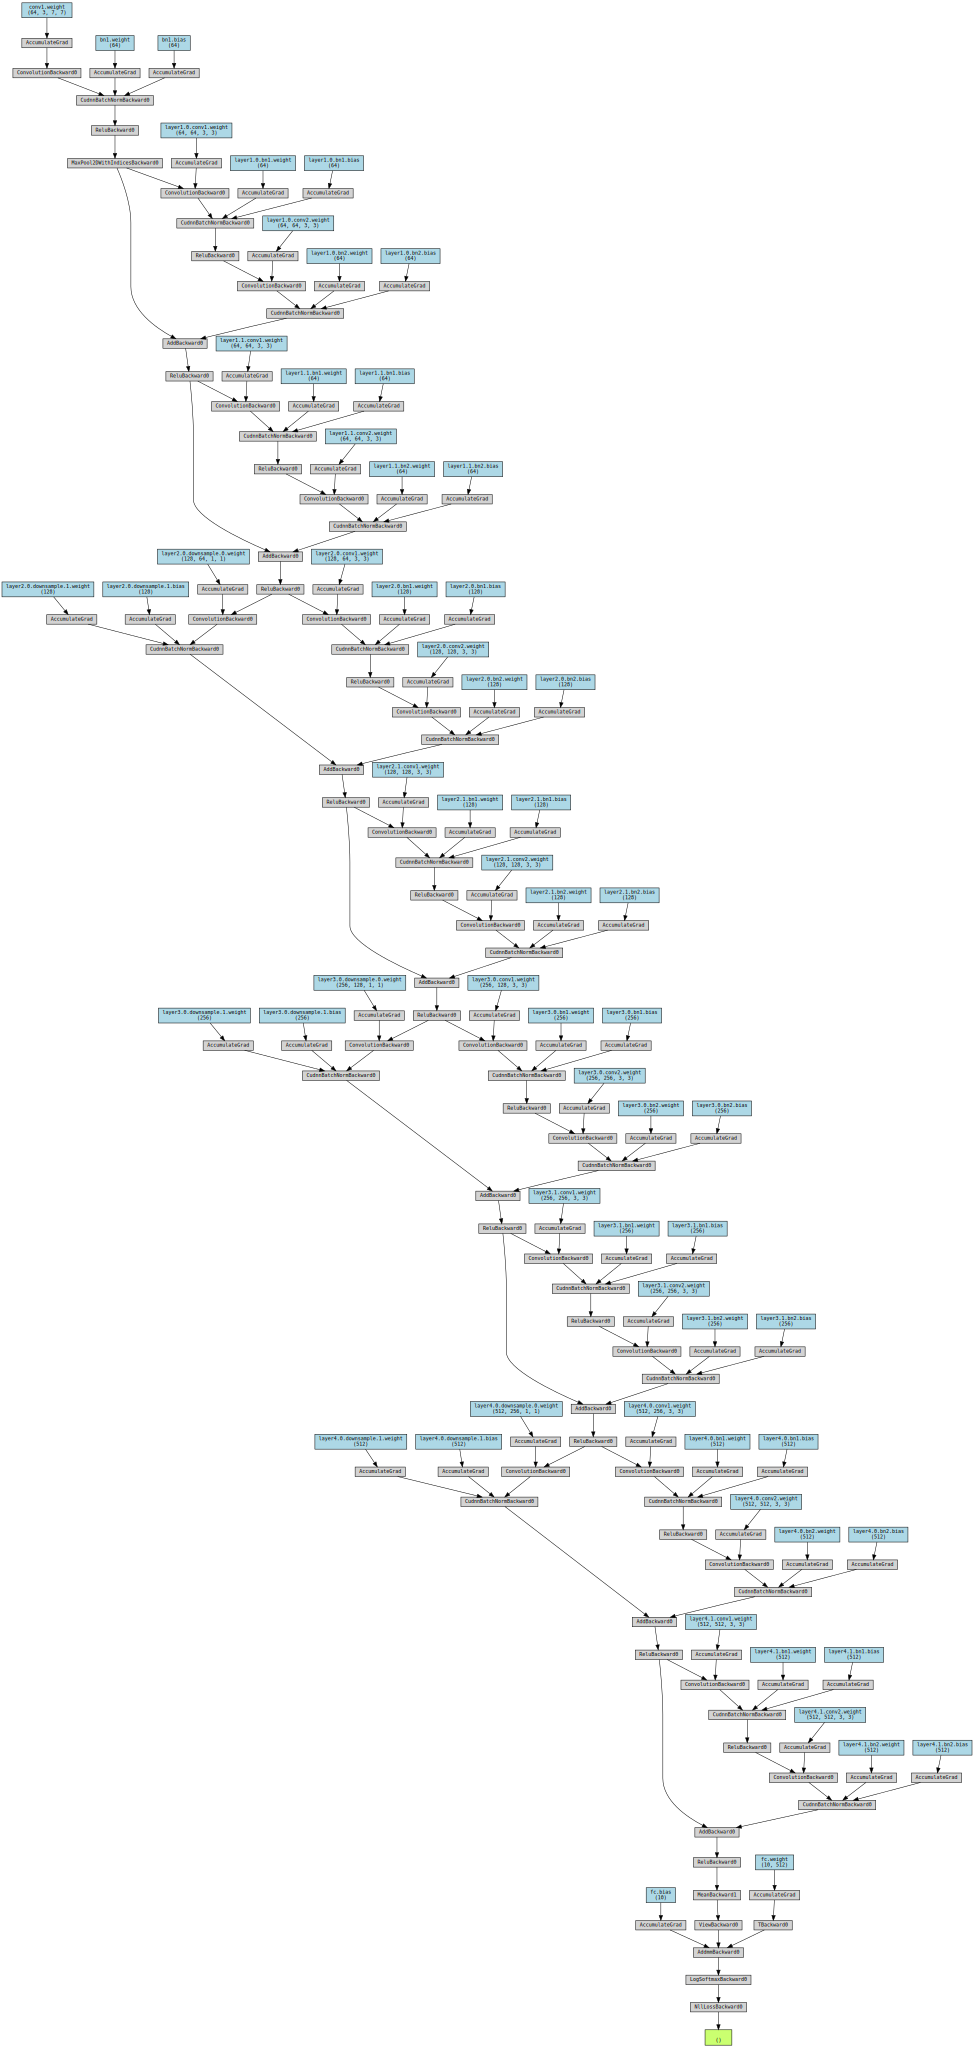

In [23]:
# 손실 계산 그래프 시각화

criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)

# loss가 동일한 디바이스에 있는지 확인
loss = loss.to(device)  # 필요하면 이동

g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

# 학습과 결과 평가

In [26]:
torch_seed()

# 사전 학습 모델 불러오기
# pretrained = True로 학습을 마친 파라미터도 함께 불러오기
net = models.resnet18(pretrained=True)

# 최종 레이어 함수 입력 차원수 확인
fc_in_features = net.fc.in_features

# 최종 레이어 함수 교체
net.fc = nn.Linear(fc_in_features, n_output)

# GPU 사용
net = net.to(device)

# 학습률
lr = 0.001

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 최적화 함수 정의
# 사전 학습 모델을 사용한다면 각 레이어 함수의 파라미터는 어느 정도 자리를 잡은 상태이기 때문에
# 복잡한 최적화 함수보다는 간단한 알고리즘이 더 좋음
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# history 파일 초기화
history = np.zeros((0, 5))

In [27]:
# 학습
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.01211 acc: 0.79276 val_loss: 0.00518, val_acc: 0.91020


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.00652 acc: 0.88802 val_loss: 0.00400, val_acc: 0.93230


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.00527 acc: 0.90858 val_loss: 0.00380, val_acc: 0.93690


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.00428 acc: 0.92610 val_loss: 0.00353, val_acc: 0.93680


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.00382 acc: 0.93400 val_loss: 0.00341, val_acc: 0.94250


초기상태 : 손실 : 0.00518  정확도 : 0.91020
최종상태 : 손실 : 0.00341 정확도 : 0.94250


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44257 (\N{HANGUL SYLLABLE GOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

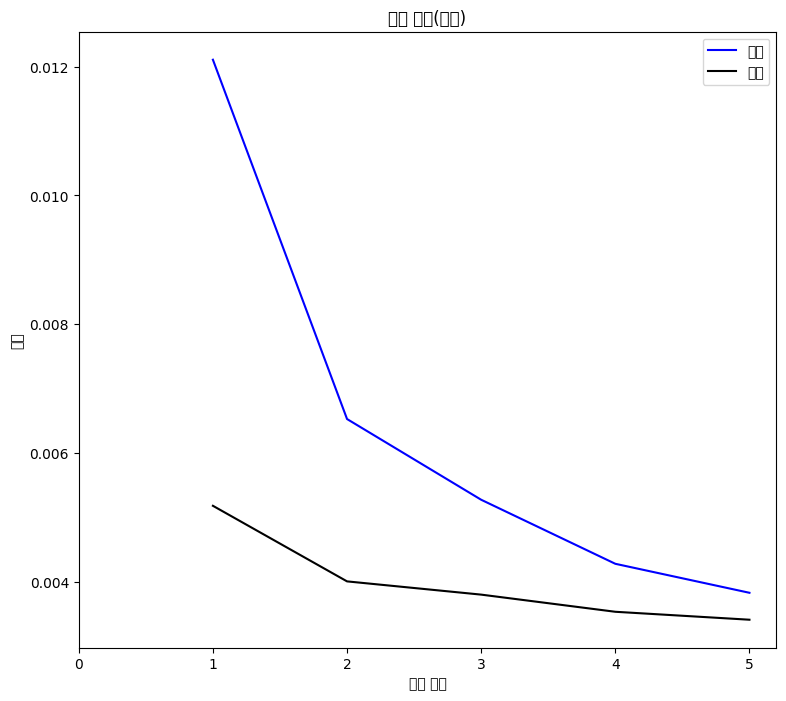

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


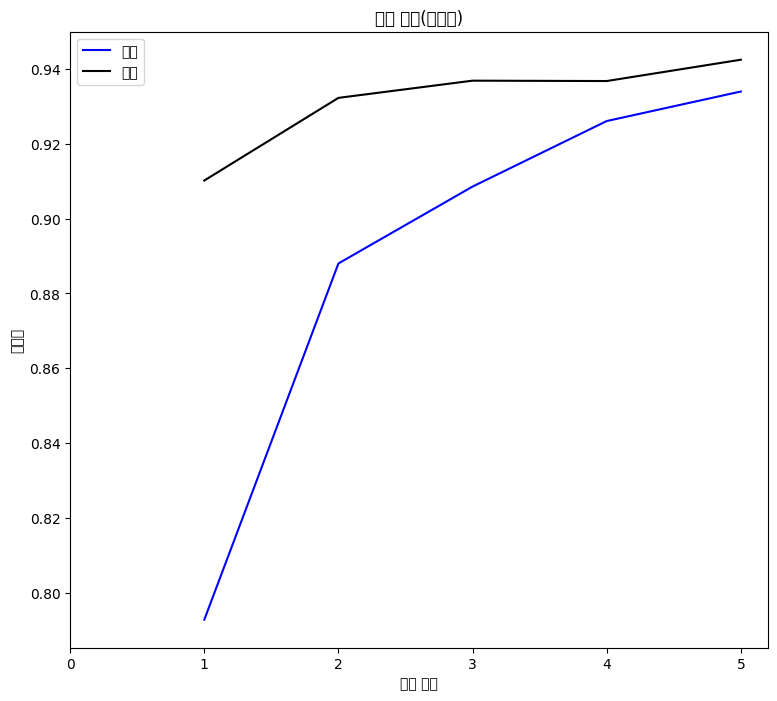

In [28]:
# 학습 결과 평가
evaluate_history(history)

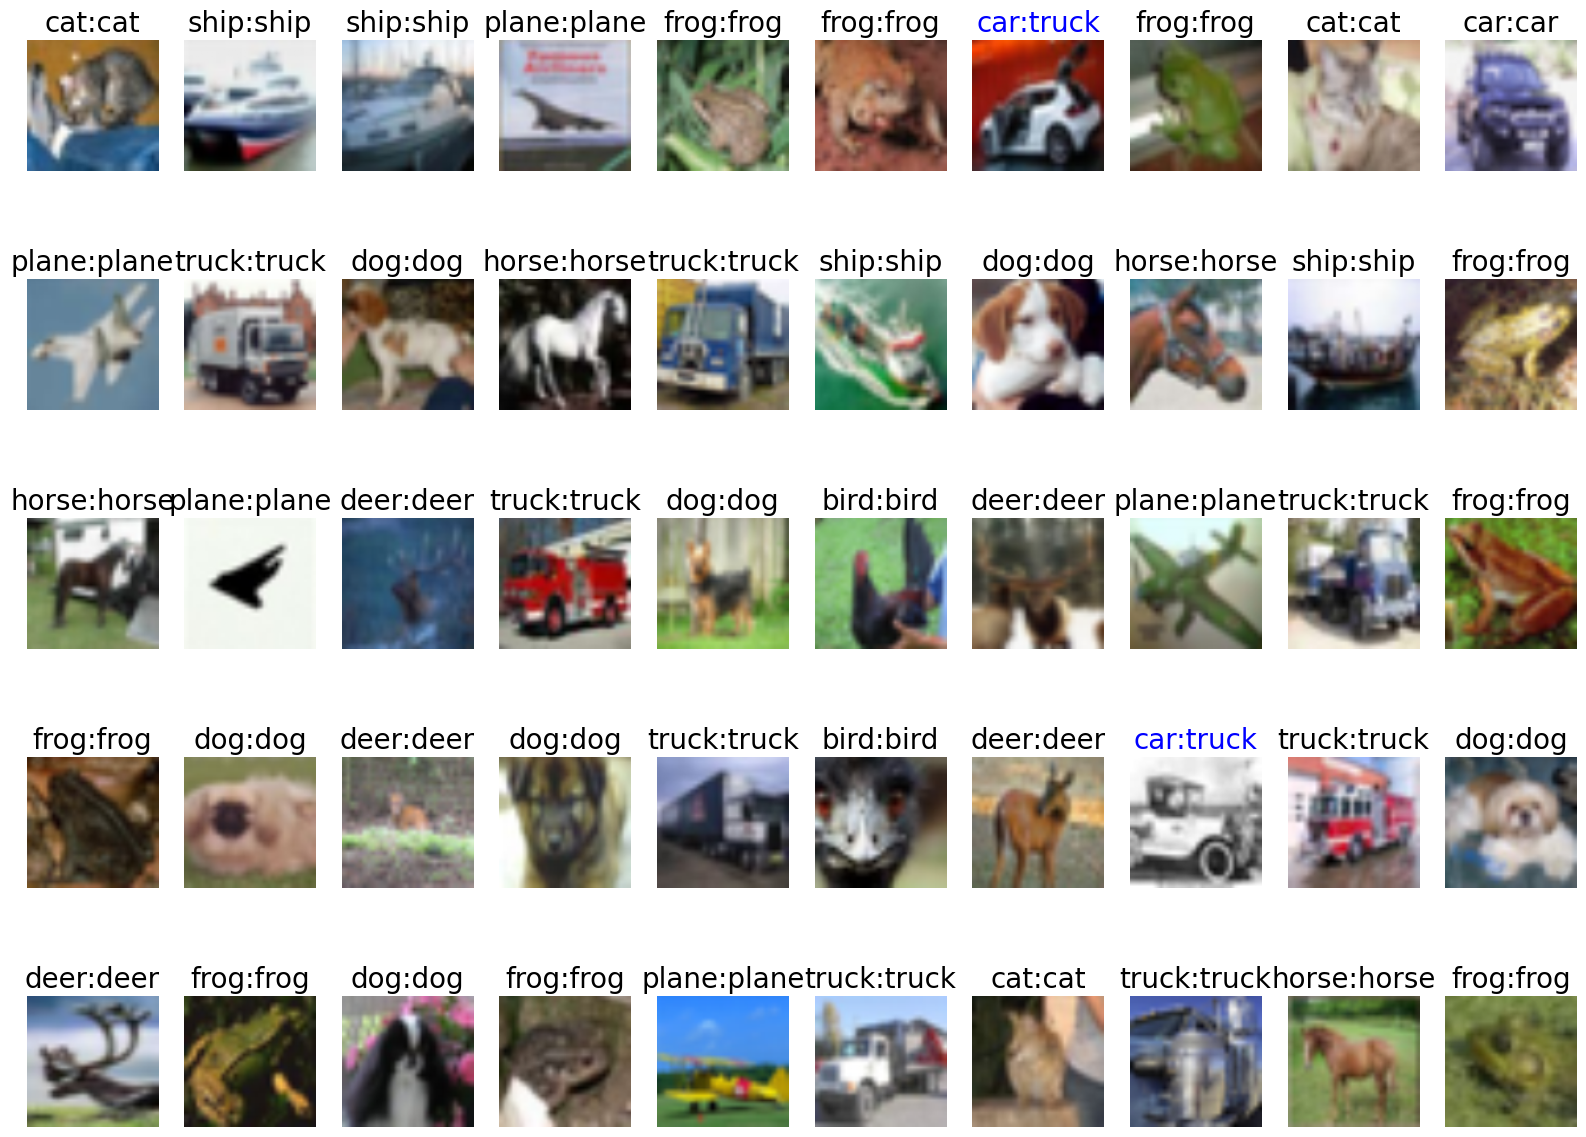

In [29]:
# 이미지와 정답, 예측 결과를 함께 표시
show_images_labels(test_loader, classes, net, device)